# Análisis exploratorio de las publicaciones con descuento
Nota: Las publicaciones con precio con descuento son aquellas que poseen el campo original_price
!= null

In [184]:
import json
from urllib.request import urlopen
import urllib
import pandas as pd
from tqdm.notebook import tqdm
import os

In [185]:
os.chdir("..") 

In [90]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.prompt { font-size: 08px !important; }</style>"))
pd.options.display.max_columns = None


# 1️⃣ Dataload 
---

In [34]:
url_base = "https://api.mercadolibre.com/"

In [32]:
url_MLA = url_base + "/sites/MLA/"

In [4]:
limit = 50 # fixed

In [5]:
items_per_category = 1000 # chosen

In [14]:
requests_per_category = int(items_per_category / limit)
requests_per_category

20

## Fxs

In [6]:
def get_data(url):
    # makes a get request given a url, and returns json response
    response = urllib.request.urlopen(url)
    return json.load(response)
    

In [16]:
def load_category_items(categ_id):
    # gets items given a category id
    url_categ = url_MLA + "search?&category={}".format(categ_id)
    all_results = [] # offset and limit must be taken into account to reach items_per_category
    for r in range(0, requests_per_category):
        offset = r * limit
        url = url_categ + "&offset={}".format(offset)
        response = get_data(url)
        results = response['results'] # keep only the items
        all_results = all_results + results
    return all_results 
    

Test

all_results = load_category_items("MLA1367")


len(all_results)

## Get root categories

In [11]:
url = url_MLA + "categories"

In [48]:
root_categories = get_data(url)
root_categories

[{'id': 'MLA5725', 'name': 'Accesorios para Vehículos'},
 {'id': 'MLA1512', 'name': 'Agro'},
 {'id': 'MLA1403', 'name': 'Alimentos y Bebidas'},
 {'id': 'MLA1071', 'name': 'Animales y Mascotas'},
 {'id': 'MLA1367', 'name': 'Antigüedades y Colecciones'},
 {'id': 'MLA1368', 'name': 'Arte, Librería y Mercería'},
 {'id': 'MLA1743', 'name': 'Autos, Motos y Otros'},
 {'id': 'MLA1384', 'name': 'Bebés'},
 {'id': 'MLA1246', 'name': 'Belleza y Cuidado Personal'},
 {'id': 'MLA1039', 'name': 'Cámaras y Accesorios'},
 {'id': 'MLA1051', 'name': 'Celulares y Teléfonos'},
 {'id': 'MLA1648', 'name': 'Computación'},
 {'id': 'MLA1144', 'name': 'Consolas y Videojuegos'},
 {'id': 'MLA1276', 'name': 'Deportes y Fitness'},
 {'id': 'MLA5726', 'name': 'Electrodomésticos y Aires Ac.'},
 {'id': 'MLA1000', 'name': 'Electrónica, Audio y Video'},
 {'id': 'MLA2547', 'name': 'Entradas para Eventos'},
 {'id': 'MLA407134', 'name': 'Herramientas y Construcción'},
 {'id': 'MLA1574', 'name': 'Hogar, Muebles y Jardín'},
 {'

## Get items per root category

In [24]:
df = pd.DataFrame() # will contain items from all root categories
for c in tqdm(root_categories):
    all_results = load_category_items(c["id"])
    df_tmp = pd.json_normalize(all_results) # build a pd df from a json with nested data (notice how lists remain lists)
    # add root category data to the df with category items
    df_tmp["root_category_id"] = c["id"]
    df_tmp["root_category_name"] = c["name"]
    # append df_tmp to the final df
    df = df.append(df_tmp, ignore_index=True)

  0%|          | 0/31 [00:00<?, ?it/s]

**Inspect final df**

In [25]:
df.shape

(30937, 132)

In [93]:
df.columns.tolist()

['id',
 'site_id',
 'title',
 'price',
 'sale_price',
 'currency_id',
 'available_quantity',
 'sold_quantity',
 'buying_mode',
 'listing_type_id',
 'stop_time',
 'condition',
 'permalink',
 'thumbnail',
 'thumbnail_id',
 'accepts_mercadopago',
 'attributes',
 'original_price',
 'category_id',
 'official_store_id',
 'domain_id',
 'catalog_product_id',
 'tags',
 'catalog_listing',
 'use_thumbnail_id',
 'order_backend',
 'seller.id',
 'seller.permalink',
 'seller.registration_date',
 'seller.car_dealer',
 'seller.real_estate_agency',
 'seller.tags',
 'seller.eshop.nick_name',
 'seller.eshop.eshop_rubro',
 'seller.eshop.eshop_id',
 'seller.eshop.eshop_locations',
 'seller.eshop.site_id',
 'seller.eshop.eshop_logo_url',
 'seller.eshop.eshop_status_id',
 'seller.eshop.seller',
 'seller.eshop.eshop_experience',
 'seller.seller_reputation.transactions.total',
 'seller.seller_reputation.transactions.canceled',
 'seller.seller_reputation.transactions.period',
 'seller.seller_reputation.transacti

Inspect specific columns values

In [ ]:
[x for x in df.columns if "address" in x]

In [ ]:
df['address.city_id'][0]

In [ ]:
df.category_id[0]

## Get subcategories info
Recursive algorithm

## TODO: metodo recursivo para ir pidiendo las subcategorias, asi le mapeo la categoria padre y la específica a cada item

- no se si sirve hacer una lista de todo el arbol de categorias????? -- emb?
- o bien mapear la categ específica a cada row ..... para aperturar el análisis que haga, y no quedarme con lo que veo a nivel root category nada más

In [69]:
def get_subcategories_from_root(categ_id, dic):
    # recursive function to get subcategories data 
    url = url_base + "categories/{}".format(categ_id)
    response = get_data(url)
    children_categories = response["children_categories"]
    for cc in children_categories: # base case: children_categories list is empty
        id = cc["id"]
        dic[id] = {"name": cc["name"], 
                    "root": response["path_from_root"]} # 'root' does not include current category as response["path_from_root"] has parent category data 
        get_subcategories_from_root(id, dic)  

Test 

In [70]:
dic = {}
res = get_subcategories_from_root("MLA4711", dic) # INFO: takes 2 minutes

In [71]:
dic

{'MLA86379': {'name': 'Alarmas para Motos',
  'root': [{'id': 'MLA5725', 'name': 'Accesorios para Vehículos'},
   {'id': 'MLA4711', 'name': 'Acc. para Motos y Cuatriciclos'}]},
 'MLA434708': {'name': 'Alforjas',
  'root': [{'id': 'MLA5725', 'name': 'Accesorios para Vehículos'},
   {'id': 'MLA4711', 'name': 'Acc. para Motos y Cuatriciclos'}]},
 'MLA11090': {'name': 'Baúles y Anclajes',
  'root': [{'id': 'MLA5725', 'name': 'Accesorios para Vehículos'},
   {'id': 'MLA4711', 'name': 'Acc. para Motos y Cuatriciclos'}]},
 'MLA86350': {'name': 'Baúles Laterales',
  'root': [{'id': 'MLA5725', 'name': 'Accesorios para Vehículos'},
   {'id': 'MLA4711', 'name': 'Acc. para Motos y Cuatriciclos'},
   {'id': 'MLA11090', 'name': 'Baúles y Anclajes'}]},
 'MLA432921': {'name': 'Baúles para Cuatriciclos',
  'root': [{'id': 'MLA5725', 'name': 'Accesorios para Vehículos'},
   {'id': 'MLA4711', 'name': 'Acc. para Motos y Cuatriciclos'},
   {'id': 'MLA11090', 'name': 'Baúles y Anclajes'}]},
 'MLA379646': {'

**Get subcategories info for all root categories**

In [124]:
# FIXME: takes a lot of time ... maybe just get subcategies from selected group of root categories instead of all

In [72]:
dic_all_categories = {}
for c in tqdm(root_categories):
    dic = {}
    get_subcategories_from_root(c["id"], dic)  
    dic_all_categories.update(dic)

  0%|          | 0/31 [00:00<?, ?it/s]

{'id': 'MLA5725', 'name': 'Accesorios para Vehículos'}
{'id': 'MLA1512', 'name': 'Agro'}
{'id': 'MLA1403', 'name': 'Alimentos y Bebidas'}
{'id': 'MLA1071', 'name': 'Animales y Mascotas'}
{'id': 'MLA1367', 'name': 'Antigüedades y Colecciones'}
{'id': 'MLA1368', 'name': 'Arte, Librería y Mercería'}
{'id': 'MLA1743', 'name': 'Autos, Motos y Otros'}
{'id': 'MLA1384', 'name': 'Bebés'}
{'id': 'MLA1246', 'name': 'Belleza y Cuidado Personal'}
{'id': 'MLA1039', 'name': 'Cámaras y Accesorios'}
{'id': 'MLA1051', 'name': 'Celulares y Teléfonos'}
{'id': 'MLA1648', 'name': 'Computación'}
{'id': 'MLA1144', 'name': 'Consolas y Videojuegos'}
{'id': 'MLA1276', 'name': 'Deportes y Fitness'}
{'id': 'MLA5726', 'name': 'Electrodomésticos y Aires Ac.'}
{'id': 'MLA1000', 'name': 'Electrónica, Audio y Video'}
{'id': 'MLA2547', 'name': 'Entradas para Eventos'}
{'id': 'MLA407134', 'name': 'Herramientas y Construcción'}
{'id': 'MLA1574', 'name': 'Hogar, Muebles y Jardín'}
{'id': 'MLA1499', 'name': 'Industrias y O

**Inspect dic_all_categories**

In [125]:
len(dic_all_categories)

9545

In [131]:
first_key = next(iter(dic_all_categories)) 
first_key

'MLA4711'

In [132]:
dic_all_categories[first_key]

{'name': 'Acc. para Motos y Cuatriciclos',
 'root': [{'id': 'MLA5725', 'name': 'Accesorios para Vehículos'}]}

# 2️⃣ Manipulate df
---

In [74]:
df.head()

,id,site_id,title,price,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,stop_time,condition,permalink,thumbnail,thumbnail_id,accepts_mercadopago,attributes,original_price,category_id,official_store_id,domain_id,catalog_product_id,tags,catalog_listing,use_thumbnail_id,order_backend,seller.id,seller.permalink,seller.registration_date,seller.car_dealer,seller.real_estate_agency,seller.tags,seller.eshop.nick_name,seller.eshop.eshop_rubro,seller.eshop.eshop_id,seller.eshop.eshop_locations,seller.eshop.site_id,seller.eshop.eshop_logo_url,seller.eshop.eshop_status_id,seller.eshop.seller,seller.eshop.eshop_experience,seller.seller_reputation.transactions.total,seller.seller_reputation.transactions.canceled,seller.seller_reputation.transactions.period,seller.seller_reputation.transactions.ratings.negative,seller.seller_reputation.transactions.ratings.positive,seller.seller_reputation.transactions.ratings.neutral,seller.seller_reputation.transactions.completed,seller.seller_reputation.power_seller_status,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,seller.seller_reputation.metrics.claims.period,seller.seller_reputation.metrics.delayed_handling_time.rate,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.delayed_handling_time.period,seller.seller_reputation.metrics.sales.period,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,seller.seller_reputation.metrics.cancellations.period,seller.seller_reputation.level_id,prices.id,prices.prices,prices.presentation.display_currency,prices.payment_method_prices,installments.quantity,installments.amount,installments.rate,installments.currency_id,address.state_id,address.state_name,address.city_id,address.city_name,shipping.free_shipping,shipping.mode,shipping.tags,shipping.logistic_type,shipping.store_pick_up,seller_address.id,seller_address.comment,seller_address.address_line,seller_address.zip_code,seller_address.country.id,seller_address.country.name,seller_address.state.id,seller_address.state.name,seller_address.city.id,seller_address.city.name,seller_address.latitude,seller_address.longitude,differential_pricing.id,seller.seller_reputation.metrics.claims.excluded.real_rate,seller.seller_reputation.metrics.claims.excluded.real_value,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_rate,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller.seller_reputation.metrics.cancellations.excluded.real_rate,seller.seller_reputation.metrics.cancellations.excluded.real_value,seller.seller_reputation.protection_end_date,seller.seller_reputation.real_level,seller.eshop.eshop_rubro.id,seller.eshop.eshop_rubro.name,seller.eshop.eshop_rubro.category_id,seller.car_dealer_logo,root_category_id,root_category_name,prices,installments,address.area_code,address.phone1,seller_contact.contact,seller_contact.other_info,seller_contact.area_code,seller_contact.phone,seller_contact.area_code2,seller_contact.phone2,seller_contact.email,seller_contact.webpage,location.address_line,location.zip_code,location.subneighborhood,location.neighborhood.id,location.neighborhood.name,location.city.id,location.city.name,location.state.id,location.state.name,location.country.id,location.country.name,location.latitude,location.longitude,seller.home_image_url,sale_terms
0,MLA833231588,MLA,Estéreo Para Auto Pioneer Mvh S215bt Con Usb Y...,12800.0,None,ARS,15,1077,buy_it_now,gold_special,2040-08-01T20:21:12.000Z,new,https://www.mercadolibre.com.ar/estereo-para-a...,http://http2.mlstatic.com/D_960260-MLA33082733...,960260-MLA33082733743_122019,True,"[{'id': 'BRAND', 'value_struct': None, 'value_...",NaN,MLA6867,NaN,MLA-VEHICLE_STEREOS,MLA14983192,"[brand_verified, good_quality_picture, good_qu...",True,True,1,9696552,http://perfil.mercadolibre.com.ar/MUNDOJW.,2002-05-31

## Add columns

**Add discount column**

In [76]:
df["discount"] = 1 - df.price / df.original_price if df.original_price is not None else None

In [122]:
df.head()

,id,site_id,title,price,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,stop_time,condition,permalink,thumbnail,thumbnail_id,accepts_mercadopago,attributes,original_price,category_id,official_store_id,domain_id,catalog_product_id,tags,catalog_listing,use_thumbnail_id,order_backend,seller.id,seller.permalink,seller.registration_date,seller.car_dealer,seller.real_estate_agency,seller.tags,seller.eshop.nick_name,seller.eshop.eshop_rubro,seller.eshop.eshop_id,seller.eshop.eshop_locations,seller.eshop.site_id,seller.eshop.eshop_logo_url,seller.eshop.eshop_status_id,seller.eshop.seller,seller.eshop.eshop_experience,seller.seller_reputation.transactions.total,seller.seller_reputation.transactions.canceled,seller.seller_reputation.transactions.period,seller.seller_reputation.transactions.ratings.negative,seller.seller_reputation.transactions.ratings.positive,seller.seller_reputation.transactions.ratings.neutral,seller.seller_reputation.transactions.completed,seller.seller_reputation.power_seller_status,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,seller.seller_reputation.metrics.claims.period,seller.seller_reputation.metrics.delayed_handling_time.rate,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.delayed_handling_time.period,seller.seller_reputation.metrics.sales.period,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,seller.seller_reputation.metrics.cancellations.period,seller.seller_reputation.level_id,prices.id,prices.prices,prices.presentation.display_currency,prices.payment_method_prices,installments.quantity,installments.amount,installments.rate,installments.currency_id,address.state_id,address.state_name,address.city_id,address.city_name,shipping.free_shipping,shipping.mode,shipping.tags,shipping.logistic_type,shipping.store_pick_up,seller_address.id,seller_address.comment,seller_address.address_line,seller_address.zip_code,seller_address.country.id,seller_address.country.name,seller_address.state.id,seller_address.state.name,seller_address.city.id,seller_address.city.name,seller_address.latitude,seller_address.longitude,differential_pricing.id,seller.seller_reputation.metrics.claims.excluded.real_rate,seller.seller_reputation.metrics.claims.excluded.real_value,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_rate,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller.seller_reputation.metrics.cancellations.excluded.real_rate,seller.seller_reputation.metrics.cancellations.excluded.real_value,seller.seller_reputation.protection_end_date,seller.seller_reputation.real_level,seller.eshop.eshop_rubro.id,seller.eshop.eshop_rubro.name,seller.eshop.eshop_rubro.category_id,seller.car_dealer_logo,root_category_id,root_category_name,prices,installments,address.area_code,address.phone1,seller_contact.contact,seller_contact.other_info,seller_contact.area_code,seller_contact.phone,seller_contact.area_code2,seller_contact.phone2,seller_contact.email,seller_contact.webpage,location.address_line,location.zip_code,location.subneighborhood,location.neighborhood.id,location.neighborhood.name,location.city.id,location.city.name,location.state.id,location.state.name,location.country.id,location.country.name,location.latitude,location.longitude,seller.home_image_url,sale_terms,discount,category_name,category_full_name
0,MLA833231588,MLA,Estéreo Para Auto Pioneer Mvh S215bt Con Usb Y...,12800.0,None,ARS,15,1077,buy_it_now,gold_special,2040-08-01T20:21:12.000Z,new,https://www.mercadolibre.com.ar/estereo-para-a...,http://http2.mlstatic.com/D_960260-MLA33082733...,960260-MLA33082733743_122019,True,"[{'id': 'BRAND', 'value_struct': None, 'value_...",NaN,MLA6867,NaN,MLA-VEHICLE_STEREOS,MLA14983192,"[brand_verified, good_quality_picture, good_qu...",True,True,1,9696552,http://perf

Inspect discount coulumn

In [86]:
df[~df.original_price.isna()][["id", "site_id", "title", "price", "sale_price", "original_price", "discount"]]

,id,site_id,title,price,sale_price,original_price,discount
7,MLA836983125,MLA,Funda Cubre Rueda Auxilio Ford Ecosport,891.00,None,990,0.1
14,MLA897397255,MLA,Camara Espejo Retrovisor Full Hd + Trasera Est...,2999.00,None,3999,0.250063
15,MLA785918507,MLA,Kit Led Cree Cob H1 H7 H3 9005 12/24v 2019 C6+...,999.00,None,1600,0.375625
17,MLA836882881,MLA,Mini Compresor De Aire Portatil 12v 250 Psi Kl...,1003.00,None,1249,0.196958
18,MLA836881964,MLA,Compresor De Aire Alto Impacto Portátil 250 Ps...,2127.00,None,2799,0.240086
...,...,...,...,...,...,...,...
30858,MLA905514102,MLA,Rack Mineria Rig Minero 6 Gpus Aluminio,7599.05,None,7999,0.05
30870,MLA879463123,MLA,Sahumo Sagrada Madre Limpieza Energética - Lla...,227.85,None,245,0.07
30887,MLA870837169,MLA,Turmalina Negra (chica) - Pacha Kuyuy,161.50,None,170,0.05
30890,MLA834986557,MLA,Resina De Jazmin India 50 Gr,218.50,None,230,0.05


**Add category name (specific one for each item)**

In [95]:
df["category_name"] = df.category_id.apply( lambda x: dic_all_categories[x]["name"] if x in dic_all_categories.keys() else None )

In [133]:
def build_str_from_root_info(lis):
    str = ""
    for r in lis[1:]: # avoid root (column root_category_name already has that info)
        str += r["name"] + " | "
    return str[:-2]

In [134]:
df["category_full_name"] = df.category_id.apply( lambda x: build_str_from_root_info(dic_all_categories[x]["root"]) if x in dic_all_categories.keys() else None )

In [135]:
df.head()

,id,site_id,title,price,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,stop_time,condition,permalink,thumbnail,thumbnail_id,accepts_mercadopago,attributes,original_price,category_id,official_store_id,domain_id,catalog_product_id,tags,catalog_listing,use_thumbnail_id,order_backend,seller.id,seller.permalink,seller.registration_date,seller.car_dealer,seller.real_estate_agency,seller.tags,seller.eshop.nick_name,seller.eshop.eshop_rubro,seller.eshop.eshop_id,seller.eshop.eshop_locations,seller.eshop.site_id,seller.eshop.eshop_logo_url,seller.eshop.eshop_status_id,seller.eshop.seller,seller.eshop.eshop_experience,seller.seller_reputation.transactions.total,seller.seller_reputation.transactions.canceled,seller.seller_reputation.transactions.period,seller.seller_reputation.transactions.ratings.negative,seller.seller_reputation.transactions.ratings.positive,seller.seller_reputation.transactions.ratings.neutral,seller.seller_reputation.transactions.completed,seller.seller_reputation.power_seller_status,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,seller.seller_reputation.metrics.claims.period,seller.seller_reputation.metrics.delayed_handling_time.rate,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.delayed_handling_time.period,seller.seller_reputation.metrics.sales.period,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,seller.seller_reputation.metrics.cancellations.period,seller.seller_reputation.level_id,prices.id,prices.prices,prices.presentation.display_currency,prices.payment_method_prices,installments.quantity,installments.amount,installments.rate,installments.currency_id,address.state_id,address.state_name,address.city_id,address.city_name,shipping.free_shipping,shipping.mode,shipping.tags,shipping.logistic_type,shipping.store_pick_up,seller_address.id,seller_address.comment,seller_address.address_line,seller_address.zip_code,seller_address.country.id,seller_address.country.name,seller_address.state.id,seller_address.state.name,seller_address.city.id,seller_address.city.name,seller_address.latitude,seller_address.longitude,differential_pricing.id,seller.seller_reputation.metrics.claims.excluded.real_rate,seller.seller_reputation.metrics.claims.excluded.real_value,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_rate,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller.seller_reputation.metrics.cancellations.excluded.real_rate,seller.seller_reputation.metrics.cancellations.excluded.real_value,seller.seller_reputation.protection_end_date,seller.seller_reputation.real_level,seller.eshop.eshop_rubro.id,seller.eshop.eshop_rubro.name,seller.eshop.eshop_rubro.category_id,seller.car_dealer_logo,root_category_id,root_category_name,prices,installments,address.area_code,address.phone1,seller_contact.contact,seller_contact.other_info,seller_contact.area_code,seller_contact.phone,seller_contact.area_code2,seller_contact.phone2,seller_contact.email,seller_contact.webpage,location.address_line,location.zip_code,location.subneighborhood,location.neighborhood.id,location.neighborhood.name,location.city.id,location.city.name,location.state.id,location.state.name,location.country.id,location.country.name,location.latitude,location.longitude,seller.home_image_url,sale_terms,discount,category_name,category_full_name
0,MLA833231588,MLA,Estéreo Para Auto Pioneer Mvh S215bt Con Usb Y...,12800.0,None,ARS,15,1077,buy_it_now,gold_special,2040-08-01T20:21:12.000Z,new,https://www.mercadolibre.com.ar/estereo-para-a...,http://http2.mlstatic.com/D_960260-MLA33082733...,960260-MLA33082733743_122019,True,"[{'id': 'BRAND', 'value_struct': None, 'value_...",NaN,MLA6867,NaN,MLA-VEHICLE_STEREOS,MLA14983192,"[brand_verified, good_quality_picture, good_qu...",True,True,1,9696552,http://perf

## Analize columns

In [206]:
df.sale_price.value_counts()

Series([], Name: sale_price, dtype: int64)

**sale_price column does not provide any useful information**

In [147]:
df["seller.eshop.eshop_rubro"].value_counts()

Series([], Name: seller.eshop.eshop_rubro, dtype: int64)

In [146]:
df["seller.eshop.eshop_rubro.id"].value_counts()

MLA1246      208
MLA5726      121
MLA1182       73
MLA3025       51
MLA1574       30
MLA1384       28
MLA1276       22
MLA435173     20
MLA1455       20
MLA1613       20
MLA6839       16
MLA3043       15
MLA109042     14
MLA109278     13
MLA1430       12
MLA1631       12
MLA1091       11
MLA6658       10
MLA3114        9
MLA3530        8
MLA412445      8
MLA409810      7
MLA1403        7
MLA1132        5
MLA109026      5
MLA1575        4
MLA1275        4
MLA1263        4
MLA3959        4
MLA1002        3
MLA4624        3
MLA10934       2
MLA1387        2
MLA12555       2
MLA1911        1
MLA6010        1
MLA110761      1
MLA5182        1
MLA1000        1
MLA12554       1
MLA1253        1
Name: seller.eshop.eshop_rubro.id, dtype: int64

In [160]:
df[["seller.eshop.eshop_rubro", "id", "seller.eshop.eshop_rubro.id", "seller.eshop.eshop_rubro.name"]].head()

,seller.eshop.eshop_rubro,id,seller.eshop.eshop_rubro.id,seller.eshop.eshop_rubro.name
0,NaN,MLA833231588,NaN,NaN
1,NaN,MLA869356478,NaN,NaN
2,NaN,MLA862644604,NaN,NaN
3,NaN,MLA851109741,NaN,NaN
4,NaN,MLA775138148,NaN,NaN


In [168]:
aux = df[["id", "seller.eshop.eshop_rubro", "seller.eshop.eshop_rubro.id", "seller.eshop.eshop_rubro.name"]]
aux[~aux["seller.eshop.eshop_rubro.id"].isna()].head()

,id,seller.eshop.eshop_rubro,seller.eshop.eshop_rubro.id,seller.eshop.eshop_rubro.name
706,MLA775628101,NaN,MLA5726,Electrodomésticos y Aires Ac.
1008,MLA603849116,NaN,MLA5726,Electrodomésticos y Aires Ac.
1028,MLA827932245,NaN,MLA1613,Baños
1029,MLA827932039,NaN,MLA1613,Baños
1040,MLA872330266,NaN,MLA5726,Electrodomésticos y Aires Ac.


In [169]:
aux[aux["seller.eshop.eshop_rubro.id"].isna()].head()

,id,seller.eshop.eshop_rubro,seller.eshop.eshop_rubro.id,seller.eshop.eshop_rubro.name
0,MLA833231588,NaN,NaN,NaN
1,MLA869356478,NaN,NaN,NaN
2,MLA862644604,NaN,NaN,NaN
3,MLA851109741,NaN,NaN,NaN
4,MLA775138148,NaN,NaN,NaN


**seller.eshop.eshop_rubro is not necessary**

In [143]:
df["seller.eshop.eshop_experience"].value_counts()

0.0       16412
2016.0       94
2012.0       58
2007.0       46
2015.0       44
1993.0       42
2008.0       41
1984.0       34
2010.0       32
1991.0       23
2013.0       23
1997.0       21
2005.0       20
2011.0       18
2003.0       18
2006.0       17
2014.0       16
1988.0       14
1992.0       13
2009.0       12
1986.0        9
1995.0        8
1970.0        8
1989.0        7
1999.0        7
1987.0        6
1968.0        6
1994.0        5
2001.0        5
1990.0        3
1961.0        3
2000.0        2
2004.0        2
1998.0        1
1974.0        1
2017.0        1
1983.0        1
Name: seller.eshop.eshop_experience, dtype: int64

<p style="color:red; font-weight: bold">preguntar: seller.eshop.eshop_experience es un campo llenado por el vendedor? (el típico "since")</p>

In [145]:
df["differential_pricing.id"].value_counts()

33678187.0    1637
35713231.0     364
35713248.0     159
33665186.0     110
35713268.0      61
35713232.0       2
Name: differential_pricing.id, dtype: int64

<p style="color:red; font-weight: bold">preguntar: differential_pricing</p>

In [152]:
df.sale_terms.any()

[{'id': 'PRICE_MODALITY',
  'name': 'Modalidad de precio',
  'value_id': '6178426',
  'value_name': 'Solicitar presupuesto',
  'value_struct': None,
  'values': [{'struct': None,
    'id': '6178426',
    'name': 'Solicitar presupuesto'}]}]

In [171]:
df[df.sale_terms.isna()].shape

(30694, 135)

In [172]:
df[~df.sale_terms.isna()].shape

(243, 135)

In [174]:
df[~df.sale_terms.isna()].head()

,id,site_id,title,price,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,stop_time,condition,permalink,thumbnail,thumbnail_id,accepts_mercadopago,attributes,original_price,category_id,official_store_id,domain_id,catalog_product_id,tags,catalog_listing,use_thumbnail_id,order_backend,seller.id,seller.permalink,seller.registration_date,seller.car_dealer,seller.real_estate_agency,seller.tags,seller.eshop.nick_name,seller.eshop.eshop_rubro,seller.eshop.eshop_id,seller.eshop.eshop_locations,seller.eshop.site_id,seller.eshop.eshop_logo_url,seller.eshop.eshop_status_id,seller.eshop.seller,seller.eshop.eshop_experience,seller.seller_reputation.transactions.total,seller.seller_reputation.transactions.canceled,seller.seller_reputation.transactions.period,seller.seller_reputation.transactions.ratings.negative,seller.seller_reputation.transactions.ratings.positive,seller.seller_reputation.transactions.ratings.neutral,seller.seller_reputation.transactions.completed,seller.seller_reputation.power_seller_status,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,seller.seller_reputation.metrics.claims.period,seller.seller_reputation.metrics.delayed_handling_time.rate,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.delayed_handling_time.period,seller.seller_reputation.metrics.sales.period,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,seller.seller_reputation.metrics.cancellations.period,seller.seller_reputation.level_id,prices.id,prices.prices,prices.presentation.display_currency,prices.payment_method_prices,installments.quantity,installments.amount,installments.rate,installments.currency_id,address.state_id,address.state_name,address.city_id,address.city_name,shipping.free_shipping,shipping.mode,shipping.tags,shipping.logistic_type,shipping.store_pick_up,seller_address.id,seller_address.comment,seller_address.address_line,seller_address.zip_code,seller_address.country.id,seller_address.country.name,seller_address.state.id,seller_address.state.name,seller_address.city.id,seller_address.city.name,seller_address.latitude,seller_address.longitude,differential_pricing.id,seller.seller_reputation.metrics.claims.excluded.real_rate,seller.seller_reputation.metrics.claims.excluded.real_value,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_rate,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller.seller_reputation.metrics.cancellations.excluded.real_rate,seller.seller_reputation.metrics.cancellations.excluded.real_value,seller.seller_reputation.protection_end_date,seller.seller_reputation.real_level,seller.eshop.eshop_rubro.id,seller.eshop.eshop_rubro.name,seller.eshop.eshop_rubro.category_id,seller.car_dealer_logo,root_category_id,root_category_name,prices,installments,address.area_code,address.phone1,seller_contact.contact,seller_contact.other_info,seller_contact.area_code,seller_contact.phone,seller_contact.area_code2,seller_contact.phone2,seller_contact.email,seller_contact.webpage,location.address_line,location.zip_code,location.subneighborhood,location.neighborhood.id,location.neighborhood.name,location.city.id,location.city.name,location.state.id,location.state.name,location.country.id,location.country.name,location.latitude,location.longitude,seller.home_image_url,sale_terms,discount,category_name,category_full_name
28131,MLA884308769,MLA,"Instalacion, Colocación Redes Proteccion Balco...",NaN,None,None,1,5,classified,gold_premium,2021-04-15T04:00:33.000Z,None,https://servicio.mercadolibre.com.ar/MLA-88430...,http://http2.mlstatic.com/D_873835-MLA30229546...,873835-MLA30229546338_052019,True,[],None,MLA58261,NaN,MLA-ENCLOSURE_SERVICES,None,"[hirable, dragged_bids_and_visits, good_qualit...",NaN,True,45,50657042,http://perfil.mercadolibre.com.ar/NES6500,2008-06-09T17:24:02

In [176]:
df[~df.sale_terms.isna()].root_category_name.value_counts()

Servicios    243
Name: root_category_name, dtype: int64

**sale_terms is present only when root category equals "Servicios"**

In [178]:
df[~df["location.state.id"].isna()].root_category_name.value_counts()

Servicios               1000
Autos, Motos y Otros    1000
Inmuebles               1000
Name: root_category_name, dtype: int64

In [189]:
cols = [
 'address.state_id',
 'address.state_name',
 'address.city_id',
 'address.city_name',
 'seller_address.state.id',
 'seller_address.state.name',
 'seller_address.city.id',
 'seller_address.city.name',
 'location.subneighborhood',
 'location.neighborhood.id',
 'location.neighborhood.name',
 'location.city.id',
 'location.city.name',
 'location.state.id',
 'location.state.name',

]

In [190]:
df[~df["location.state.id"].isna()][cols].head()

,address.state_id,address.state_name,address.city_id,address.city_name,seller_address.state.id,seller_address.state.name,seller_address.city.id,seller_address.city.name,location.subneighborhood,location.neighborhood.id,location.neighborhood.name,location.city.id,location.city.name,location.state.id,location.state.name
5983,TUxBUEdSQWU4ZDkz,Bs.As. G.B.A. Norte,TUxBQ1RJRzk0ZjQw,Tigre,AR-B,Buenos Aires,None,pilar,None,TUxBQlRJRzU0MDla,Tigre,TUxBQ1RJRzk0ZjQw,Tigre,TUxBUEdSQWU4ZDkz,Bs.As. G.B.A. Norte
5984,TUxBUEdSQWU4ZDkz,Bs.As. G.B.A. Norte,TUxBQ0VTQzQ3YTc0,Escobar,AR-B,Buenos Aires,TUxBQ0VTQzQ3YTc0,Escobar,None,TUxBQkJFTDY3NDda,Belén de Escobar,TUxBQ0VTQzQ3YTc0,Escobar,TUxBUEdSQWU4ZDkz,Bs.As. G.B.A. Norte
5985,TUxBUEdSQWU4ZDkz,Bs.As. G.B.A. Norte,TUxBQ1BJTGFyMTIz,Pilar,AR-B,Buenos Aires,None,pilar,None,TVhYQXN0b24gVmlsbGFnZVRVeEJRMUJKVEdGe,Aston Village,TUxBQ1BJTGFyMTIz,Pilar,TUxBUEdSQWU4ZDkz,Bs.As. G.B.A. Norte
5986,TUxBUENBUGw3M2E1,Capital Federal,TUxBQ0NBUGZlZG1sYQ,Capital Federal,AR-B,Buenos Aires,TUxBQ1ZJQ2E3MTQz,Vicente López,None,TUxBQkxBQjk1ODJa,La Boca,TUxBQ0NBUGZlZG1sYQ,Capital Federal,TUxBUENBUGw3M2E1,Capital Federal
5987,TUxBUEdSQWU4ZDkz,Bs.As. G.B.A. Norte,TUxBQ0VTQzQ3YTc0,Escobar,AR-B,Buenos Aires,TUxBQ0VTQzQ3YTc0,Escobar,None,TUxBQkJFTDY3NDda,Belén de Escobar,TUxBQ0VTQzQ3YTc0,Escobar,TUxBUEdSQWU4ZDkz,Bs.As. G.B.A. Norte


In [193]:
df[
    (~df["location.state.id"].isna()) & 
    (df["location.state.id"] != df["address.state_id"])
][cols].head()

,address.state_id,address.state_name,address.city_id,address.city_name,seller_address.state.id,seller_address.state.name,seller_address.city.id,seller_address.city.name,location.subneighborhood,location.neighborhood.id,location.neighborhood.name,location.city.id,location.city.name,location.state.id,location.state.name


In [199]:
df[
    (~df["seller_address.state.id"].isna()) & 
    (df["seller_address.state.id"] == df["address.state_id"])
][cols].shape

(27938, 15)

In [198]:
df[
    (~df["seller_address.state.id"].isna()) & 
    (df["seller_address.state.id"] != df["address.state_id"])
][cols].shape

(2999, 15)

In [203]:
df[
    (~df["seller_address.state.id"].isna()) & 
    (df["seller_address.state.id"] != df["address.state_id"])
][["address.state_name", "address.state_id", "seller_address.state.name", "seller_address.state.id"]].drop_duplicates()

,address.state_name,address.state_id,seller_address.state.name,seller_address.state.id
5983,Bs.As. G.B.A. Norte,TUxBUEdSQWU4ZDkz,Buenos Aires,AR-B
5986,Capital Federal,TUxBUENBUGw3M2E1,Buenos Aires,AR-B
5988,Capital Federal,TUxBUENBUGw3M2E1,Capital Federal,AR-C
5989,Bs.As. G.B.A. Sur,TUxBUEdSQXJlMDNm,Capital Federal,AR-C
6099,Bs.As. G.B.A. Norte,TUxBUEdSQWU4ZDkz,Capital Federal,AR-C
6101,Bs.As. G.B.A. Oeste,TUxBUEdSQWVmNTVm,Buenos Aires,AR-B
6118,Bs.As. G.B.A. Sur,TUxBUEdSQXJlMDNm,Buenos Aires,AR-B
6200,Buenos Aires Interior,TUxBUFpPTmFpbnRl,Buenos Aires,AR-B
6222,Bs.As. G.B.A. Oeste,TUxBUEdSQWVmNTVm,Capital Federal,AR-C
6272,Bs.As. Costa Atlántica,TUxBUENPU2ExMmFkMw,Buenos Aires,AR-B


<p style="color:red; font-weight: bold">preguntar: address vs seller.address vs location</p>
addess state id parece ser la única necesaria ........... es igual a location si está, y es más específica que la del seller pero está incluida ahí

## Choose a subset of columns and persist final df

In [180]:
columns = [
 'id',
 'site_id',
 'title',
 'price',
 'currency_id',
 'available_quantity',
 'sold_quantity',
 'buying_mode',
 'listing_type_id',
 'stop_time',
 'condition',
 'accepts_mercadopago',
 'attributes',
 'original_price',
 'category_id',
 'official_store_id',
 'domain_id',
 'catalog_product_id',
 'tags',
 'catalog_listing',
 'seller.id',
 'seller.registration_date',
 'seller.car_dealer',
 'seller.real_estate_agency',
 'seller.tags',
 'seller.seller_reputation.transactions.total',
 'seller.seller_reputation.transactions.canceled',
 'seller.seller_reputation.transactions.period',
 'seller.seller_reputation.transactions.ratings.negative',
 'seller.seller_reputation.transactions.ratings.positive',
 'seller.seller_reputation.transactions.ratings.neutral',
 'seller.seller_reputation.transactions.completed',
 'seller.seller_reputation.power_seller_status',
 'seller.seller_reputation.metrics.claims.rate',
 'seller.seller_reputation.metrics.claims.value',
 'seller.seller_reputation.metrics.claims.period',
 'seller.seller_reputation.metrics.delayed_handling_time.rate',
 'seller.seller_reputation.metrics.delayed_handling_time.value',
 'seller.seller_reputation.metrics.delayed_handling_time.period',
 'seller.seller_reputation.metrics.sales.period',
 'seller.seller_reputation.metrics.sales.completed',
 'seller.seller_reputation.metrics.cancellations.rate',
 'seller.seller_reputation.metrics.cancellations.value',
 'seller.seller_reputation.metrics.cancellations.period',
 'seller.seller_reputation.level_id',
 'prices.prices',
 'address.state_id',
 'address.state_name',
 'address.city_id',
 'address.city_name',
 'shipping.free_shipping',
 'shipping.mode',
 'shipping.tags',
 'shipping.logistic_type',
 'shipping.store_pick_up',
 'seller_address.id',
 'seller_address.country.id',
 'seller_address.country.name',
 'seller_address.state.id',
 'seller_address.state.name',
 'seller_address.city.id',
 'seller_address.city.name', 
 'differential_pricing.id',
 'seller.seller_reputation.metrics.claims.excluded.real_rate',
 'seller.seller_reputation.metrics.claims.excluded.real_value',
 'seller.seller_reputation.metrics.delayed_handling_time.excluded.real_rate',
 'seller.seller_reputation.metrics.delayed_handling_time.excluded.real_value',
 'seller.seller_reputation.metrics.cancellations.excluded.real_rate',
 'seller.seller_reputation.metrics.cancellations.excluded.real_value',
 'seller.seller_reputation.protection_end_date',
 'seller.seller_reputation.real_level',
 'seller.eshop.eshop_rubro.id',
 'seller.eshop.eshop_rubro.name',
 'seller.eshop.eshop_rubro.category_id',
 'root_category_id',
 'root_category_name',
 'seller_contact.contact',
 'seller_contact.phone',
 'seller_contact.email',
 'seller_contact.webpage',
 'location.neighborhood.id',
 'location.neighborhood.name',
 'location.city.id',
 'location.city.name',
 'location.state.id',
 'location.state.name',
 'location.country.id',
 'location.country.name', 
 'sale_terms',
 'discount'
]

In [183]:
len(columns)

90

In [182]:
df_final = df.copy()[columns] 
df_final.head()

,id,site_id,title,price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,stop_time,condition,accepts_mercadopago,attributes,original_price,category_id,official_store_id,domain_id,catalog_product_id,tags,catalog_listing,seller.id,seller.registration_date,seller.car_dealer,seller.real_estate_agency,seller.tags,seller.seller_reputation.transactions.total,seller.seller_reputation.transactions.canceled,seller.seller_reputation.transactions.period,seller.seller_reputation.transactions.ratings.negative,seller.seller_reputation.transactions.ratings.positive,seller.seller_reputation.transactions.ratings.neutral,seller.seller_reputation.transactions.completed,seller.seller_reputation.power_seller_status,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,seller.seller_reputation.metrics.claims.period,seller.seller_reputation.metrics.delayed_handling_time.rate,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.delayed_handling_time.period,seller.seller_reputation.metrics.sales.period,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,seller.seller_reputation.metrics.cancellations.period,seller.seller_reputation.level_id,prices.prices,address.state_id,address.state_name,address.city_id,address.city_name,shipping.free_shipping,shipping.mode,shipping.tags,shipping.logistic_type,shipping.store_pick_up,seller_address.id,seller_address.country.id,seller_address.country.name,seller_address.state.id,seller_address.state.name,seller_address.city.id,seller_address.city.name,differential_pricing.id,seller.seller_reputation.metrics.claims.excluded.real_rate,seller.seller_reputation.metrics.claims.excluded.real_value,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_rate,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller.seller_reputation.metrics.cancellations.excluded.real_rate,seller.seller_reputation.metrics.cancellations.excluded.real_value,seller.seller_reputation.protection_end_date,seller.seller_reputation.real_level,seller.eshop.eshop_rubro.id,seller.eshop.eshop_rubro.name,seller.eshop.eshop_rubro.category_id,root_category_id,root_category_name,seller_contact.contact,seller_contact.phone,seller_contact.email,seller_contact.webpage,location.neighborhood.id,location.neighborhood.name,location.city.id,location.city.name,location.state.id,location.state.name,location.country.id,location.country.name,sale_terms,discount
0,MLA833231588,MLA,Estéreo Para Auto Pioneer Mvh S215bt Con Usb Y...,12800.0,ARS,15,1077,buy_it_now,gold_special,2040-08-01T20:21:12.000Z,new,True,"[{'id': 'BRAND', 'value_struct': None, 'value_...",NaN,MLA6867,NaN,MLA-VEHICLE_STEREOS,MLA14983192,"[brand_verified, good_quality_picture, good_qu...",True,9696552,2002-05-31T00:00:00.000-04:00,False,False,"[normal, user_info_verified, credits_priority_...",49198.0,3457.0,historic,0.02,0.97,0.01,45741.0,platinum,0.0120,79.0,60 days,0.0125,75.0,60 days,60 days,6154.0,0.0064,42.0,60 days,5_green,"[{'id': '6', 'type': 'standard', 'conditions':...",AR-C,Capital Federal,TUxBQkZMTzg5MjFa,Floresta,True,me2,"[fulfillment, self_service_in, mandatory_free_...",fulfillment,False,,AR,Argentina,AR-C,Capital Federal,TUxBQkZMTzg5MjFa,Floresta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MLA5725,Accesorios para Vehículos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MLA869356478,MLA,Neumático Pirelli Formula Energy 185/60 R14 82h,8998.0,ARS,124,1435,buy_it_now,gold_special,2040-07-16T04:00:00.000Z,new,True,"[{'attribute_group_name': 'Otros', 'source': 1...",NaN,MLA22195,143,MLA-AUTOMOTIVE_TIRES,MLA15000133,"[brand_verified, good_quality_picture, good_qu...",True,116026826,2014-08-01T14:48:29.000-04:00,False,False,"[brand, user_info_verified, large_seller, esho...",22602.0,970.0,historic,0.01,0.96,0.03,21632.0,platinum,0.0045,17.0,60 

**Export final df**

In [186]:
data_path = "Data/"
file_name = data_path + "data.csv"

In [204]:
df_final.to_csv(file_name, sep='\t', encoding='utf-8', index=False)

# 1️⃣ Analysis 
---

### discount

In [208]:
df_final[
    (df_final.discount.isna())
].shape

(27254, 90)

In [212]:
df_final_discount = df_final[
    ~(df_final.discount.isna())
]
df_final_discount.shape

(3683, 90)

<AxesSubplot:>

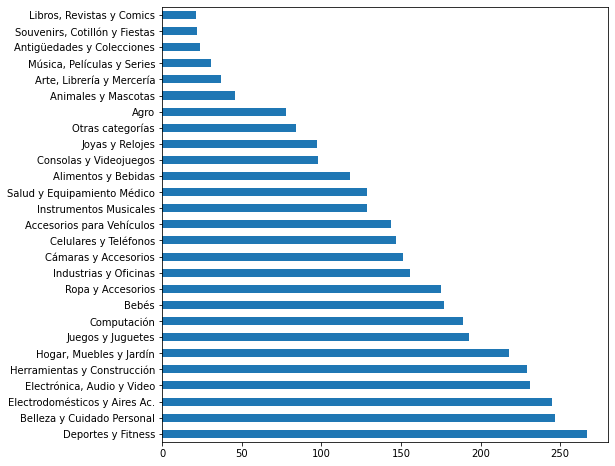

In [241]:
df_final_discount.root_category_name.value_counts().plot.barh(figsize=(8,8))

In [227]:
df_final_discount.dtypes["discount"]
df_final_discount.discount = df_final_discount.discount.apply(pd.to_numeric)

c:\users\a309549\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [235]:
df_final_discount.groupby("root_category_name").agg({
    'discount': ['mean', 'min', 'max', 'count']
}).sort_values(('discount', 'count'), ascending=False)

discount                          
                                   mean       min       max count
root_category_name                                               
Deportes y Fitness             0.198002  0.049915  0.478696   267
Belleza y Cuidado Personal     0.224392  0.050000  0.679931   247
Electrodomésticos y Aires Ac.  0.190943  0.050000  0.500042   245
Electrónica, Audio y Video     0.191643  0.005716  0.550250   231
Herramientas y Construcción    0.173969  0.049881  0.730000   229
Hogar, Muebles y Jardín        0.182458  0.046549  0.520002   218
Juegos y Juguetes              0.145190  0.047634  0.583565   193
Computación                    0.216132  0.050000  0.512317   189
Bebés                          0.192368  0.049993  0.616253   177
Ropa y Accesorios              0.176472  0.050000  0.603656   175
Industrias y Oficinas          0.170766  0.049864  0.684474   156
Cámaras y Accesorios           0.212302  0.048500  0.503333   151
Celulares y Teléfonos          0.174756  0.019878  0.617696   147
Accesorios para Vehículos      0.194069  0.049999  0.411765   144
Instrumentos Musicales         0.149424  0.049999  0.474844   129
Salud y Equipamiento Médico    0.192042  0.049998  0.516753   129
Alimentos y Bebidas            0.169712  0.026786  0.551552   118
Consolas y Videojuegos         0.171042  0.050000  0.480000    98
Joyas y Relojes                0.107614  0.050000  0.360000    97
Otras categorías               0.102500  0.050000  0.360000    84
Agro                           0.147112  0.049999  0.418333    78
Animales y Mascotas            0.097488  0.050000  0.266071    46
Arte, Librería y Mercería      0.079427  0.049988  0.170003    37
Música, Películas y Series     0.150705  0.050000  0.421222    31
Antigüedades y Colecciones     0.064167  0.050000  0.110000    24
Souvenirs, Cotillón y Fiestas  0.104806  0.049998  0.620000    22
Libros, Revistas y Comics      0.090000  0.050000  0.260000    21